In [ ]:
!pip -q install pandas numpy scikit-learn matplotlib tensorflow pillow


In [ ]:
!pip -q install wordcloud pandas matplotlib


## **Mounting Google Drive in Google Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Environment Setup and Dataset Loading**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Bidirectional, Dense, Dropout,
    Concatenate, GlobalAveragePooling2D, Layer
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

BASE_DIR = "/content/drive/MyDrive/dataset_final_thesis"
OUT_DIR  = os.path.join(BASE_DIR, "final_all_results")
os.makedirs(OUT_DIR, exist_ok=True)

CSV_PATH = os.path.join(OUT_DIR, "FINAL_MATCHED_ONLY.csv")
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"❌ CSV পাওয়া যায়নি: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)
print("✅ CSV loaded:", df.shape)


✅ CSV loaded: (1894, 5)


## **Data Preprocessing**

In [ ]:
def pick_col(cols, keys):
    cols_l = [str(c).lower() for c in cols]
    for k in keys:
        for i, c in enumerate(cols_l):
            if k in c:
                return df.columns[i]
    return None

text_col  = pick_col(df.columns, ["text_clean", "text"])
label_col = pick_col(df.columns, ["label"])
img_col   = pick_col(df.columns, ["img_path", "clean_path", "path"])

if text_col is None or label_col is None or img_col is None:
    raise ValueError("❌ CSV এ text/label/img_path column missing")

df["text"]     = df[text_col].fillna("").astype(str)
df["label"]    = df[label_col].astype(int)
df["img_path"] = df[img_col].astype(str)

def fix_path(p):
    p = str(p)
    if os.path.isabs(p):
        return p
    return os.path.join(BASE_DIR, p)

df["img_path"] = df["img_path"].apply(fix_path)

df = df[df["img_path"].apply(os.path.exists)].reset_index(drop=True)

print("✅ After filtering images:", df.shape)
print("✅ Label dist:", df["label"].value_counts().to_dict())


✅ After filtering images: (1894, 6)
✅ Label dist: {1: 1104, 0: 790}


## **Train–Validation–Test Split**

In [ ]:
train_df, temp_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["label"]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"]
)

y_train = train_df["label"].values
y_val   = val_df["label"].values
y_test  = test_df["label"].values

print("✅ Train/Val/Test:", len(train_df), len(val_df), len(test_df))


✅ Train/Val/Test: 1515 189 190


# **Text Preprocessing**

In [ ]:
MAX_WORDS = 40000
MAX_LEN   = 120
EMB_DIM   = 200

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["text"].tolist())

def to_seq(texts):
    seq = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=MAX_LEN, padding="post", truncating="post")

Xtr_text = to_seq(train_df["text"].tolist())
Xva_text = to_seq(val_df["text"].tolist())
Xte_text = to_seq(test_df["text"].tolist())

vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)
print("✅ Vocab:", vocab_size, "Text shape:", Xtr_text.shape)


✅ Vocab: 5546 Text shape: (1515, 120)


## **Image Preprocessing**

In [ ]:
IMG_SIZE = 224

def load_image(path):
    img = Image.open(path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    return np.array(img).astype(np.float32)

def make_img_array(paths):
    X = np.zeros((len(paths), IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
    for i, p in enumerate(paths):
        X[i] = load_image(p)
    return X

Xtr_img = make_img_array(train_df["img_path"].tolist())
Xva_img = make_img_array(val_df["img_path"].tolist())
Xte_img = make_img_array(test_df["img_path"].tolist())

print("✅ Image shapes:", Xtr_img.shape, Xva_img.shape, Xte_img.shape)


✅ Image shapes: (1515, 224, 224, 3) (189, 224, 224, 3) (190, 224, 224, 3)


## **Image Feature Extraction using ResNet50**

In [ ]:
img_backbone = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
img_preprocess = tf.keras.applications.resnet50.preprocess_input
img_backbone.trainable = False

Xtr_img = img_preprocess(Xtr_img)
Xva_img = img_preprocess(Xva_img)
Xte_img = img_preprocess(Xte_img)

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6)
]

print("✅ ResNet50 ready")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ ResNet50 ready


## **Attention Mechanism for Text Representation**

In [ ]:
class SimpleAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_W",
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True
        )
        self.b = self.add_weight(
            name="att_b",
            shape=(input_shape[1], 1),
            initializer="zeros",
            trainable=True
        )
        super().build(input_shape)

    def call(self, x):
        e = tf.matmul(x, self.W) + self.b
        a = tf.nn.softmax(e, axis=1)
        context = tf.reduce_sum(x * a, axis=1)
        return context

print("✅ Attention layer ready")


✅ Attention layer ready


## **Model Training and Evaluation**

In [ ]:
def train_eval_save(model, model_name, thr=0.5):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    model.fit(
        [Xtr_text, Xtr_img], y_train,
        validation_data=([Xva_text, Xva_img], y_val),
        epochs=15,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    prob = model.predict([Xte_text, Xte_img], verbose=0).ravel()
    pred = (prob >= thr).astype(int)

    print("\n====", model_name, f"(thr={thr}) ====")
    print(classification_report(y_test, pred, digits=4))

    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix - {model_name} (thr={thr})")
    plt.tight_layout()

    cm_path = os.path.join(OUT_DIR, f"CM_{model_name}_thr{thr}.png")
    plt.savefig(cm_path, dpi=300, bbox_inches="tight")
    plt.show()

    report = classification_report(y_test, pred, output_dict=True, zero_division=0)

    row = {
        "model": model_name,
        "threshold": thr,
        "accuracy": report["accuracy"],
        "precision_macro": report["macro avg"]["precision"],
        "recall_macro": report["macro avg"]["recall"],
        "f1_macro": report["macro avg"]["f1-score"]
    }
    print("✅ CM saved:", cm_path)
    return row


## **Proposed Attention-Based Multimodal Architecture**

In [ ]:
text_in = Input(shape=(MAX_LEN,), name="text_in")
x = Embedding(vocab_size, EMB_DIM)(text_in)
seq = Bidirectional(LSTM(128, return_sequences=True))(x)
tvec = SimpleAttention()(seq)
tvec = Dropout(0.3)(tvec)

img_in = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="img_in")
v = img_backbone(img_in)
v = GlobalAveragePooling2D()(v)
v = Dropout(0.3)(v)

z = Concatenate()([tvec, v])
z = Dense(128, activation="relu")(z)
z = Dropout(0.3)(z)
out = Dense(1, activation="sigmoid")(z)

model = Model([text_in, img_in], out)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_in             │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 120, 200)  │  1,109,200 │ text_in[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_in (InputLayer) │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 120, 256)  │    336,896 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ img_in[0][0]      │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_attention    │ (None, 256)       │        376 │ bidirectional[0]… │
│ (SimpleAttention)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ simple_attention… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2304)      │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    295,040 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,329,353 (96.62 MB)

 Trainable params: 1,741,641 (6.64 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## **Performance Evaluation of the Proposed Model**

Epoch 1/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 250ms/step - accuracy: 0.7378 - loss: 0.6130 - val_accuracy: 0.8783 - val_loss: 0.3415 - learning_rate: 0.0010
Epoch 2/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.8839 - loss: 0.3270 - val_accuracy: 0.8783 - val_loss: 0.3416 - learning_rate: 0.0010
Epoch 3/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.8791 - loss: 0.3028 - val_accuracy: 0.8942 - val_loss: 0.3231 - learning_rate: 0.0010
Epoch 4/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.8841 - loss: 0.2678 - val_accuracy: 0.8783 - val_loss: 0.3147 - learning_rate: 0.0010
Epoch 5/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.8994 - loss: 0.2380 - val_accuracy: 0.8889 - val_loss: 0.3028 - learning_rate: 0.0010
Epoch 6/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.9092 - loss: 0.2207 - val_accuracy: 0.8995 - val_loss: 0.3242 - learning_rate: 0.0010
Epoch 7/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.9326 - loss: 0.1927 -

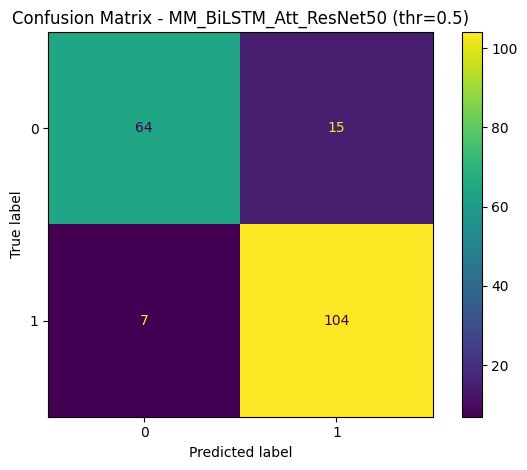

✅ CM saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/CM_MM_BiLSTM_Att_ResNet50_thr0.5.png
✅ Results saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/RESULTS2_MM_BiLSTM_ATT_RESNET50.csv


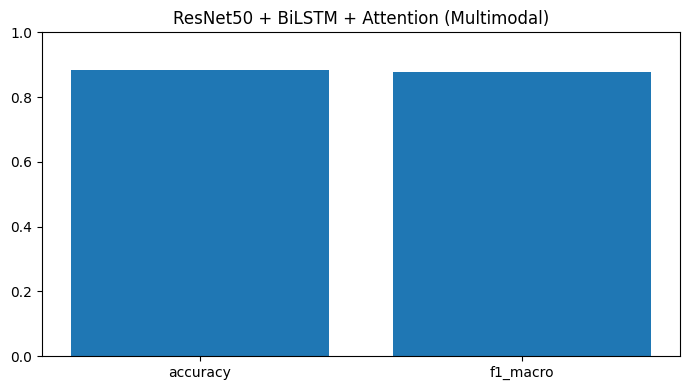

✅ Plot saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/PLOT2_MM_BiLSTM_ATT_RESNET50.png


In [ ]:
row = train_eval_save(model, "MM_BiLSTM_Att_ResNet50", thr=0.5)

results_df = pd.DataFrame([row])
results_csv = os.path.join(OUT_DIR, "RESULTS2_MM_BiLSTM_ATT_RESNET50.csv")
results_df.to_csv(results_csv, index=False, encoding="utf-8-sig")
print("✅ Results saved:", results_csv)

plt.figure(figsize=(7,4))
plt.bar(["accuracy", "f1_macro"], [row["accuracy"], row["f1_macro"]])
plt.ylim(0, 1)
plt.title("ResNet50 + BiLSTM + Attention (Multimodal)")
plt.tight_layout()

plot_path = os.path.join(OUT_DIR, "PLOT2_MM_BiLSTM_ATT_RESNET50.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()
print("✅ Plot saved:", plot_path)


In [ ]:
# =========================
# CELL A1: Build helper models to extract BiLSTM sequence + compute attention weights
# Needs: model, Xte_text, y_test, tokenizer, OUT_DIR, SimpleAttention, MAX_LEN
# =========================

import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

assert "model" in globals(), "❌ model not found"
assert "Xte_text" in globals(), "❌ Xte_text not found"
assert "y_test" in globals(), "❌ y_test not found"
assert "tokenizer" in globals(), "❌ tokenizer not found"
assert "OUT_DIR" in globals(), "❌ OUT_DIR not found"

# 1) Find SimpleAttention layer
att_layer = None
for lyr in model.layers:
    if isinstance(lyr, SimpleAttention):
        att_layer = lyr
        break
if att_layer is None:
    raise ValueError("❌ SimpleAttention layer not found in model")

# 2) Find Bidirectional(LSTM(return_sequences=True)) layer robustly
bilstm_layer = None
for lyr in model.layers:
    if isinstance(lyr, tf.keras.layers.Bidirectional):
        inner = None
        if hasattr(lyr, "layer"):
            inner = lyr.layer
        elif hasattr(lyr, "forward_layer"):
            inner = lyr.forward_layer
        if inner is not None and isinstance(inner, tf.keras.layers.LSTM) and getattr(inner, "return_sequences", False):
            bilstm_layer = lyr
            break

if bilstm_layer is None:
    # fallback by name
    for lyr in model.layers:
        if "bilstm" in lyr.name.lower() or "bidirectional" in lyr.name.lower():
            bilstm_layer = lyr
            break

if bilstm_layer is None:
    raise ValueError("❌ BiLSTM(return_sequences=True) layer not found")

# 3) Create submodel: text_in -> BiLSTM sequence output
seq_model = tf.keras.Model(inputs=model.input[0], outputs=bilstm_layer.output)

# 4) Get attention parameters W,b from trained attention layer
W, b = att_layer.get_weights()     # W:(hidden,1), b:(time,1)
W = tf.constant(W, dtype=tf.float32)
b = tf.constant(b, dtype=tf.float32)

@tf.function
def compute_attn_weights(x_seq):
    # x_seq: (B,T,H)
    e = tf.matmul(x_seq, W) + b     # (B,T,1)
    a = tf.nn.softmax(e, axis=1)    # (B,T,1)
    return tf.squeeze(a, axis=-1)   # (B,T)

print("✅ Helper ready: seq_model + compute_attn_weights()")
print("BiLSTM output shape example:", seq_model.output_shape)


✅ Helper ready: seq_model + compute_attn_weights()
BiLSTM output shape example: (None, 120, 256)


In [ ]:
# =========================
# CELL A2: Compute attention weights on TEST and save per-sample metrics
# Outputs: ATTENTION_METRICS_TEST.csv
# =========================

# Compute BiLSTM sequences for test text
x_seq = seq_model.predict(Xte_text, batch_size=64, verbose=0)     # (N,T,H)
a = compute_attn_weights(tf.constant(x_seq)).numpy()              # (N,T)

eps = 1e-12

# Core attention metrics
entropy = -np.sum(a * np.log(a + eps), axis=1)                    # (N,)
max_w   = np.max(a, axis=1)
mean_w  = np.mean(a, axis=1)
std_w   = np.std(a, axis=1)
effective_tokens = 1.0 / np.sum(a**2, axis=1)                     # "effective span"

def topk_mass(weights, k):
    idx = np.argpartition(-weights, kth=k-1, axis=1)[:, :k]
    return np.take_along_axis(weights, idx, axis=1).sum(axis=1)

top5_mass  = topk_mass(a, 5)
top10_mass = topk_mass(a, 10)

df_att = pd.DataFrame({
    "idx": np.arange(len(y_test)),
    "label": y_test.astype(int),
    "top5_mass": top5_mass,
    "top10_mass": top10_mass,
    "entropy": entropy,
    "max": max_w,
    "mean": mean_w,
    "std": std_w,
    "effective_tokens": effective_tokens
})

save_path = os.path.join(OUT_DIR, "ATTENTION_METRICS_TEST_MM_BiLSTM_Att_ResNet50.csv")
df_att.to_csv(save_path, index=False, encoding="utf-8-sig")
print("✅ Saved:", save_path)
display(df_att.head(10))


✅ Saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/ATTENTION_METRICS_TEST_MM_BiLSTM_Att_ResNet50.csv


,idx,label,top5_mass,top10_mass,entropy,max,mean,std,effective_tokens
0,0,1,0.044573,0.087667,4.787243,0.008984,0.008333,0.000186,119.940170
1,1,1,0.044391,0.087711,4.787239,0.008947,0.008333,0.000187,119.939392
2,2,1,0.044245,0.088199,4.787184,0.008899,0.008333,0.000207,119.925728
3,3,1,0.044304,0.088354,4.787168,0.008889,0.008333,0.000213,119.921547
4,4,1,0.044530,0.087669,4.787226,0.008975,0.008333,0.000192,119.936287
5,5,0,0.044424,0.087684,4.787232,0.008954,0.008333,0.000190,119.937691
6,6,0,0.044287,0.087927,4.787213,0.008926,0.008333,0.000197,119.932938
7,7,1,0.044272,0.087832,4.787249,0.008923,0.008333,0.000184,119.941284
8,8,1,0.044215,0.088050,4.787214,0.008908,0.008333,0.000197,119.932892
9,9,0,0.044349,0.087536,4.787313,0.008939,0.008333,0.000159,119.956573


In [ ]:
# =========================
# CELL A3: Summary metrics overall + class-wise
# Outputs: ATTENTION_METRICS_SUMMARY.csv
# =========================

summary_all = df_att.drop(columns=["idx","label"]).describe().T[["mean","std","min","max"]]
summary_by_class = df_att.groupby("label").mean(numeric_only=True)

print("==== Overall (TEST) ====")
display(summary_all)

print("\n==== Class-wise mean (label 0 vs 1) ====")
display(summary_by_class)

# Save summary
sum_path = os.path.join(OUT_DIR, "ATTENTION_METRICS_SUMMARY_MM_BiLSTM_Att_ResNet50.csv")
with pd.ExcelWriter(sum_path.replace(".csv",".xlsx")) as writer:
    summary_all.to_excel(writer, sheet_name="overall")
    summary_by_class.to_excel(writer, sheet_name="by_class")

print("✅ Saved summary XLSX:", sum_path.replace(".csv",".xlsx"))


==== Overall (TEST) ====


,mean,std,min,max
top5_mass,0.044458,2.465793e-04,0.044186,0.045924
top10_mass,0.087924,3.259625e-04,0.087404,0.090324
entropy,4.787197,1.320830e-04,4.785769,4.787339
max,0.008957,5.372457e-05,0.008885,0.009256
mean,0.008333,6.388059e-09,0.008333,0.008333
std,0.000200,3.223484e-05,0.000146,0.000485
effective_tokens,119.929153,3.102786e-02,119.595314,119.962975



==== Class-wise mean (label 0 vs 1) ====


,idx,top5_mass,top10_mass,entropy,max,mean,std,effective_tokens
label,,,,,,,,
0,94.721519,0.044465,0.087807,4.787227,0.008962,0.008333,0.000191,119.936325
1,94.342342,0.044452,0.088007,4.787175,0.008953,0.008333,0.000206,119.924034


✅ Saved summary XLSX: /content/drive/MyDrive/dataset_final_thesis/final_all_results/ATTENTION_METRICS_SUMMARY_MM_BiLSTM_Att_ResNet50.xlsx


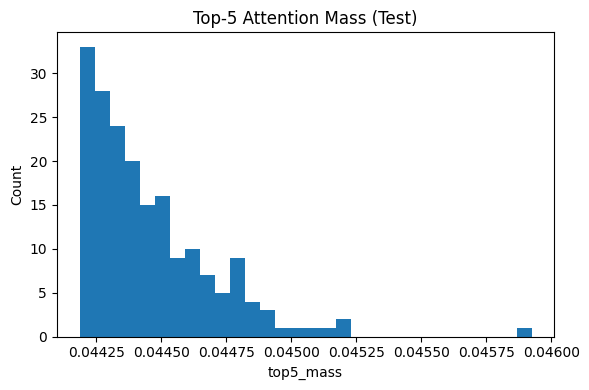

✅ Saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/PLOT_ATT_TOP5MASS.png


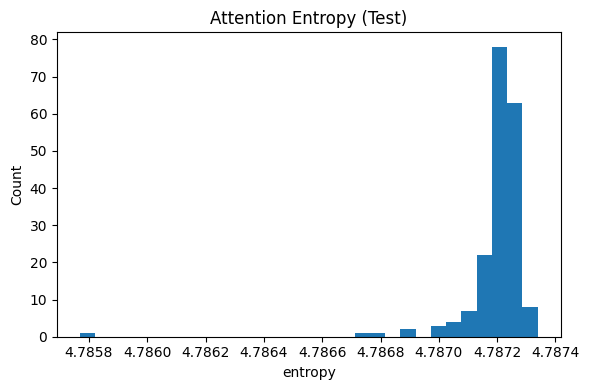

✅ Saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/PLOT_ATT_ENTROPY.png


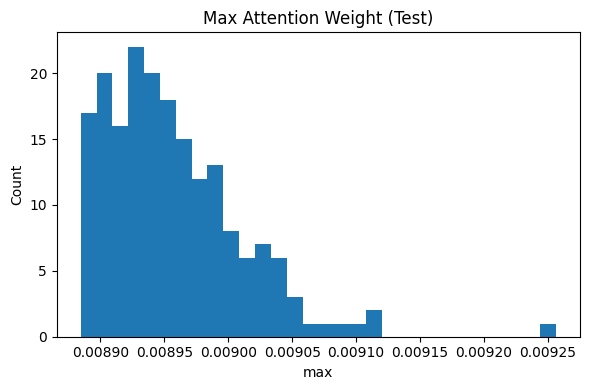

✅ Saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/PLOT_ATT_MAX.png


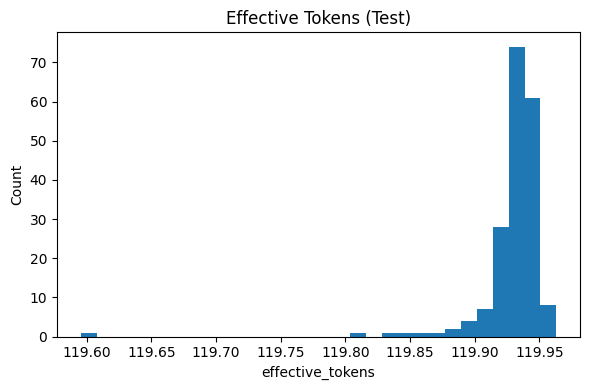

✅ Saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/PLOT_ATT_EFFECTIVE_TOKENS.png


In [ ]:
# =========================
# CELL A4: Plot attention metrics distributions + save PNGs
# =========================

def save_hist(col, title, filename, bins=30):
    plt.figure(figsize=(6,4))
    plt.hist(df_att[col], bins=bins)
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    path = os.path.join(OUT_DIR, filename)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()
    print("✅ Saved:", path)

save_hist("top5_mass", "Top-5 Attention Mass (Test)", "PLOT_ATT_TOP5MASS.png")
save_hist("entropy", "Attention Entropy (Test)", "PLOT_ATT_ENTROPY.png")
save_hist("max", "Max Attention Weight (Test)", "PLOT_ATT_MAX.png")
save_hist("effective_tokens", "Effective Tokens (Test)", "PLOT_ATT_EFFECTIVE_TOKENS.png")


==== ATTENTION METRICS (backend-style table) ====


,attention_block,n,top5_mass_mean,top5_mass_std,entropy_mean,entropy_std,max_mean,max_std,effective_tokens_mean,effective_tokens_std,status
0,ALL_TEST,190,0.044458,0.000246,4.787197,0.000132,0.008957,0.000054,119.929153,0.030946,OK
1,LABEL_0_ONLY,79,0.044465,0.000186,4.787227,0.000050,0.008962,0.000039,119.936310,0.011937,OK
2,LABEL_1_ONLY,111,0.044452,0.000281,4.787175,0.000164,0.008953,0.000062,119.924049,0.038405,OK



==== ATTENTION SUMMARY (single-row) ====


,gpu,num_test,label0_count,label1_count,top5_mass_mean,entropy_mean,max_mean,effective_tokens_mean,notes
0,/physical_device:GPU:0,190,79,111,0.044458,4.787197,0.008957,119.929153,Attention metrics computed from trained Simple...


✅ Saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/ATTN_METRICS_TABLE_MM_BiLSTM_Att_ResNet50.csv
✅ Saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/ATTN_METRICS_SUMMARY_MM_BiLSTM_Att_ResNet50.csv
✅ Saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/ATTN_METRICS_PER_SAMPLE_MM_BiLSTM_Att_ResNet50.csv


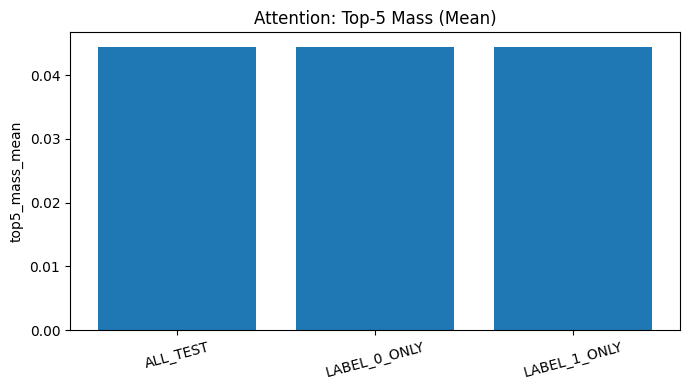

✅ Saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/PLOT_ATT_TOP5MASS_MEAN.png


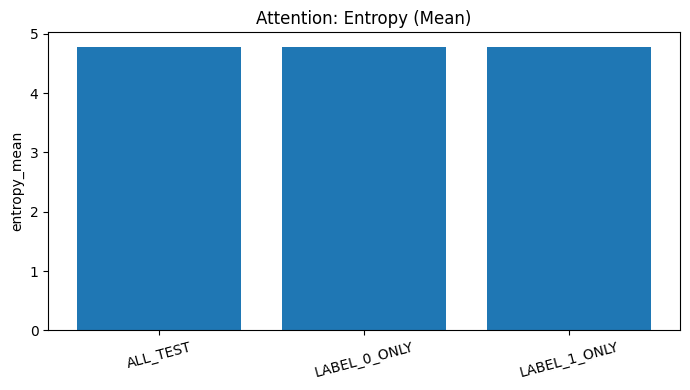

✅ Saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/PLOT_ATT_ENTROPY_MEAN.png


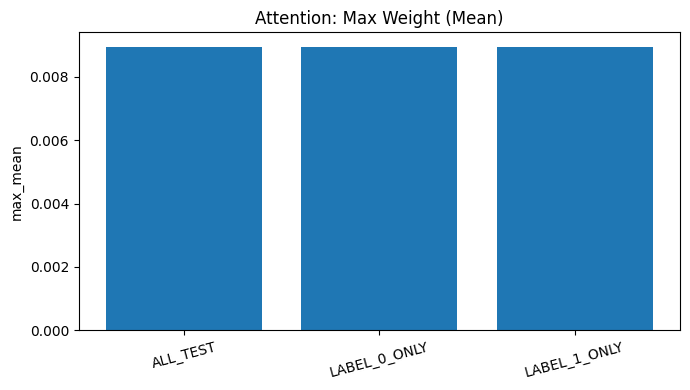

✅ Saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/PLOT_ATT_MAX_MEAN.png


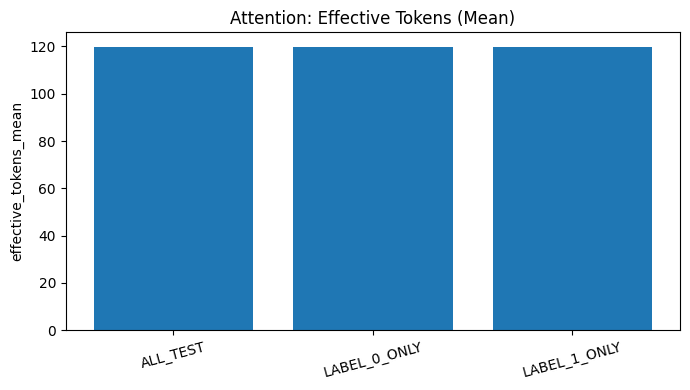

✅ Saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/PLOT_ATT_EFFECTIVE_TOKENS_MEAN.png


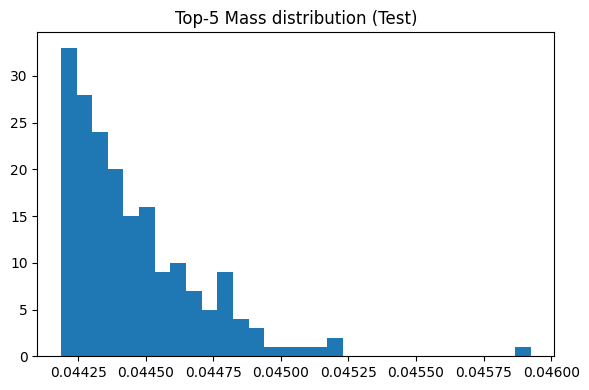

✅ Saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/PLOT_ATT_TOP5MASS_HIST.png


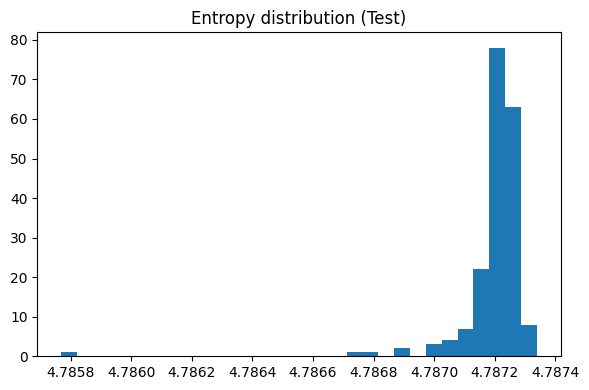

✅ Saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/PLOT_ATT_ENTROPY_HIST.png


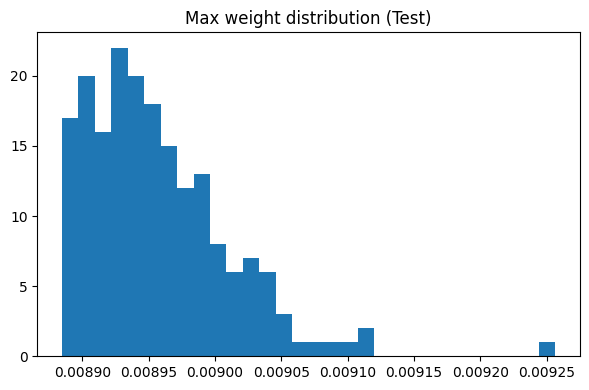

✅ Saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/PLOT_ATT_MAX_HIST.png


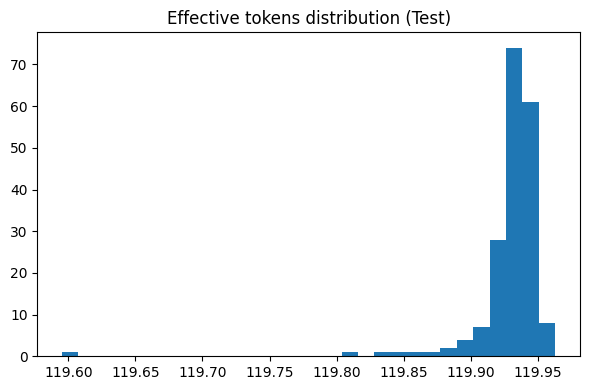

✅ Saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/PLOT_ATT_EFFECTIVE_TOKENS_HIST.png


In [ ]:
# =========================
# EXTRA CELL: Attention-metrics in "backend-table style" + save + plots
# (NO change to your previous TF model code)
# Run AFTER Cell 7 (needs: model, Xte_text, y_test, tokenizer, OUT_DIR, SimpleAttention)
# =========================

import os, numpy as np, pandas as pd, tensorflow as tf, matplotlib.pyplot as plt

assert "model" in globals(), "❌ model not found"
assert "Xte_text" in globals(), "❌ Xte_text not found"
assert "y_test" in globals(), "❌ y_test not found"
assert "OUT_DIR" in globals(), "❌ OUT_DIR not found"
assert "tokenizer" in globals(), "❌ tokenizer not found"

# ---------- Helper: find layers ----------
att_layer = None
for lyr in model.layers:
    if isinstance(lyr, SimpleAttention):
        att_layer = lyr
        break
if att_layer is None:
    raise ValueError("❌ SimpleAttention layer not found in model.")

bilstm_layer = None
for lyr in model.layers:
    if isinstance(lyr, tf.keras.layers.Bidirectional):
        inner = None
        if hasattr(lyr, "layer"):
            inner = lyr.layer
        elif hasattr(lyr, "forward_layer"):
            inner = lyr.forward_layer
        if inner is not None and isinstance(inner, tf.keras.layers.LSTM) and getattr(inner, "return_sequences", False):
            bilstm_layer = lyr
            break

if bilstm_layer is None:
    # fallback by name
    for lyr in model.layers:
        if "bilstm" in lyr.name.lower() or "bidirectional" in lyr.name.lower():
            bilstm_layer = lyr
            break
if bilstm_layer is None:
    raise ValueError("❌ BiLSTM(return_sequences=True) layer not found.")

# ---------- Submodel: text -> seq ----------
seq_model = tf.keras.Model(inputs=model.input[0], outputs=bilstm_layer.output)

# ---------- compute attention weights using SAME W,b ----------
W, b = att_layer.get_weights()
W = tf.constant(W, dtype=tf.float32)
b = tf.constant(b, dtype=tf.float32)

@tf.function
def compute_attn_weights(x_seq):
    e = tf.matmul(x_seq, W) + b
    a = tf.nn.softmax(e, axis=1)
    return tf.squeeze(a, axis=-1)  # (N,T)

# ---------- run ----------
x_seq = seq_model.predict(Xte_text, batch_size=64, verbose=0)
a = compute_attn_weights(tf.constant(x_seq)).numpy()  # (N,T)

eps = 1e-12
entropy = -np.sum(a * np.log(a + eps), axis=1)
max_w   = np.max(a, axis=1)
eff_tokens = 1.0 / np.sum(a**2, axis=1)

def topk_mass(weights, k):
    idx = np.argpartition(-weights, kth=k-1, axis=1)[:, :k]
    return np.take_along_axis(weights, idx, axis=1).sum(axis=1)

top5 = topk_mass(a, 5)
top10 = topk_mass(a, 10)

# ---------- per-sample df ----------
df_att = pd.DataFrame({
    "label": y_test.astype(int),
    "top5_mass": top5,
    "top10_mass": top10,
    "entropy": entropy,
    "max": max_w,
    "effective_tokens": eff_tokens
})

# ---------- "backend-like table" rows ----------
def row_stats(name, subset_df):
    return {
        "attention_block": name,
        "n": int(len(subset_df)),
        "top5_mass_mean": float(subset_df["top5_mass"].mean()),
        "top5_mass_std": float(subset_df["top5_mass"].std(ddof=0)),
        "entropy_mean": float(subset_df["entropy"].mean()),
        "entropy_std": float(subset_df["entropy"].std(ddof=0)),
        "max_mean": float(subset_df["max"].mean()),
        "max_std": float(subset_df["max"].std(ddof=0)),
        "effective_tokens_mean": float(subset_df["effective_tokens"].mean()),
        "effective_tokens_std": float(subset_df["effective_tokens"].std(ddof=0)),
        "status": "OK"
    }

df_att_backend = pd.DataFrame([
    row_stats("ALL_TEST", df_att),
    row_stats("LABEL_0_ONLY", df_att[df_att["label"]==0]),
    row_stats("LABEL_1_ONLY", df_att[df_att["label"]==1]),
])

# ---------- summary (single-row like your screenshot bottom table) ----------
gpu_name = "CPU"
try:
    gpus = tf.config.list_physical_devices("GPU")
    if len(gpus) > 0:
        gpu_name = gpus[0].name
except:
    pass

df_att_summary = pd.DataFrame([{
    "gpu": gpu_name,
    "num_test": int(len(df_att)),
    "label0_count": int((df_att["label"]==0).sum()),
    "label1_count": int((df_att["label"]==1).sum()),
    "top5_mass_mean": float(df_att["top5_mass"].mean()),
    "entropy_mean": float(df_att["entropy"].mean()),
    "max_mean": float(df_att["max"].mean()),
    "effective_tokens_mean": float(df_att["effective_tokens"].mean()),
    "notes": "Attention metrics computed from trained SimpleAttention weights"
}])

print("==== ATTENTION METRICS (backend-style table) ====")
display(df_att_backend)

print("\n==== ATTENTION SUMMARY (single-row) ====")
display(df_att_summary)

# ---------- SAVE CSV ----------
csv1 = os.path.join(OUT_DIR, "ATTN_METRICS_TABLE_MM_BiLSTM_Att_ResNet50.csv")
csv2 = os.path.join(OUT_DIR, "ATTN_METRICS_SUMMARY_MM_BiLSTM_Att_ResNet50.csv")
csv3 = os.path.join(OUT_DIR, "ATTN_METRICS_PER_SAMPLE_MM_BiLSTM_Att_ResNet50.csv")

df_att_backend.to_csv(csv1, index=False, encoding="utf-8-sig")
df_att_summary.to_csv(csv2, index=False, encoding="utf-8-sig")
df_att.assign(idx=np.arange(len(df_att))).to_csv(csv3, index=False, encoding="utf-8-sig")

print("✅ Saved:", csv1)
print("✅ Saved:", csv2)
print("✅ Saved:", csv3)

# ---------- PLOTS (save like your sdpa plots) ----------
def save_bar(metric_col, title, filename):
    plt.figure(figsize=(7,4))
    plt.bar(df_att_backend["attention_block"], df_att_backend[metric_col])
    plt.title(title)
    plt.ylabel(metric_col)
    plt.xticks(rotation=15)
    plt.tight_layout()
    p = os.path.join(OUT_DIR, filename)
    plt.savefig(p, dpi=300, bbox_inches="tight")
    plt.show()
    print("✅ Saved:", p)

save_bar("top5_mass_mean", "Attention: Top-5 Mass (Mean)", "PLOT_ATT_TOP5MASS_MEAN.png")
save_bar("entropy_mean", "Attention: Entropy (Mean)", "PLOT_ATT_ENTROPY_MEAN.png")
save_bar("max_mean", "Attention: Max Weight (Mean)", "PLOT_ATT_MAX_MEAN.png")
save_bar("effective_tokens_mean", "Attention: Effective Tokens (Mean)", "PLOT_ATT_EFFECTIVE_TOKENS_MEAN.png")

# distribution plots
def save_hist(series, title, filename, bins=30):
    plt.figure(figsize=(6,4))
    plt.hist(series, bins=bins)
    plt.title(title)
    plt.tight_layout()
    p = os.path.join(OUT_DIR, filename)
    plt.savefig(p, dpi=300, bbox_inches="tight")
    plt.show()
    print("✅ Saved:", p)

save_hist(df_att["top5_mass"], "Top-5 Mass distribution (Test)", "PLOT_ATT_TOP5MASS_HIST.png")
save_hist(df_att["entropy"], "Entropy distribution (Test)", "PLOT_ATT_ENTROPY_HIST.png")
save_hist(df_att["max"], "Max weight distribution (Test)", "PLOT_ATT_MAX_HIST.png")
save_hist(df_att["effective_tokens"], "Effective tokens distribution (Test)", "PLOT_ATT_EFFECTIVE_TOKENS_HIST.png")


==== Overall Attention Metrics (TEST) ====


,mean,std,min,max
top5_mass,0.053119,1.269196e-03,0.048572,0.055106
entropy,4.784296,1.043722e-03,4.781521,4.786159
max,0.010789,1.777956e-04,0.010341,0.011293
mean,0.008333,6.284123e-09,0.008333,0.008333
std,0.000678,1.142741e-04,0.000438,0.000941
effective_tokens,119.190025,2.649571e-01,118.489548,119.669640
top10_mass,0.102831,3.466975e-03,0.094564,0.108574



==== Class-wise mean metrics ====


,top5_mass,entropy,max,mean,std,effective_tokens,top10_mass
label,,,,,,,
0,0.053638,4.784022,0.010858,0.008333,0.000711,119.11908,0.104113
1,0.052749,4.784489,0.010740,0.008333,0.000654,119.24054,0.101920


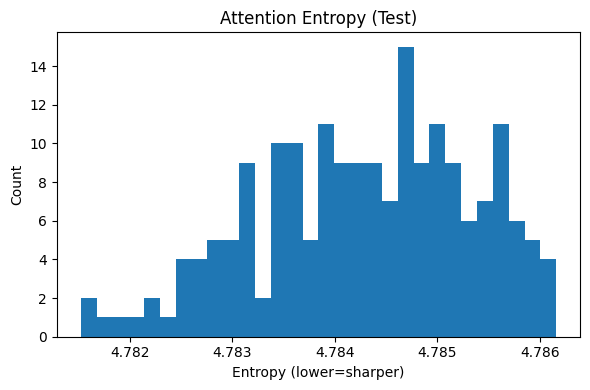

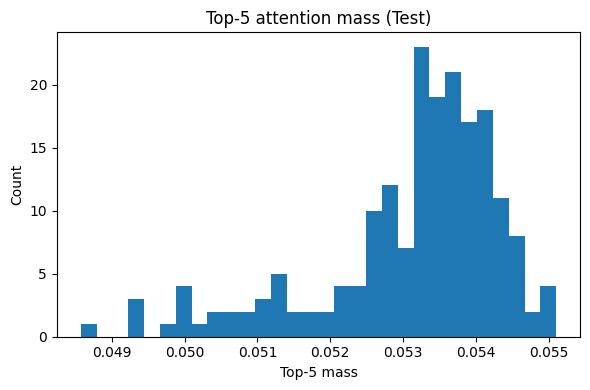

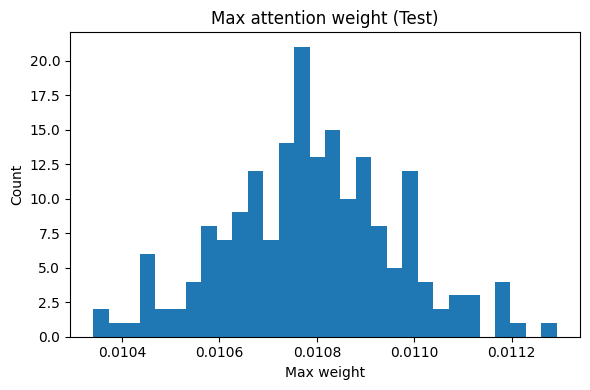

✅ Saved: /content/drive/MyDrive/dataset_final_thesis/final_all_results/ATTENTION_METRICS_MM_BiLSTM_Att_ResNet50_TEST.csv


In [ ]:
# =========================
# EXTRA CELL (FIXED): Attention Metrics for SimpleAttention
# No change to your main training code
# =========================

import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

# 1) Find the attention layer
att_layer = None
for lyr in model.layers:
    if isinstance(lyr, SimpleAttention):
        att_layer = lyr
        break
if att_layer is None:
    raise ValueError("❌ SimpleAttention layer not found in model.")

# 2) Find the BiLSTM(return_sequences=True) layer robustly
bilstm_layer = None
for lyr in model.layers:
    if isinstance(lyr, tf.keras.layers.Bidirectional):
        # TF/Keras version ভেদে layer attribute আলাদা হতে পারে
        inner = None
        if hasattr(lyr, "layer"):  # some versions
            inner = lyr.layer
        elif hasattr(lyr, "forward_layer"):  # common in newer versions
            inner = lyr.forward_layer

        if inner is not None and isinstance(inner, tf.keras.layers.LSTM):
            if getattr(inner, "return_sequences", False):
                bilstm_layer = lyr
                break

if bilstm_layer is None:
    # fallback: by name search (যদি type match না করে)
    for lyr in model.layers:
        if "bidirectional" in lyr.name.lower():
            bilstm_layer = lyr
            break

if bilstm_layer is None:
    raise ValueError("❌ Bidirectional LSTM layer not found.")

# 3) Submodel: text_input -> BiLSTM sequence output
seq_model = tf.keras.Model(inputs=model.input[0], outputs=bilstm_layer.output)

# 4) Compute attention weights using SAME W,b from your attention layer
W, b = att_layer.get_weights()  # W:(hidden,1) , b:(time,1)
W = tf.constant(W, dtype=tf.float32)
b = tf.constant(b, dtype=tf.float32)

@tf.function
def compute_attn_weights(x_seq):
    # x_seq: (B,T,H)
    e = tf.matmul(x_seq, W) + b
    a = tf.nn.softmax(e, axis=1)
    return tf.squeeze(a, axis=-1)  # (B,T)

# 5) Run on test text
x_seq = seq_model.predict(Xte_text, batch_size=64, verbose=0)   # (N,T,H)
a = compute_attn_weights(tf.constant(x_seq)).numpy()            # (N,T)

# 6) Metrics per sample
eps = 1e-12
entropy = -np.sum(a * np.log(a + eps), axis=1)
max_w = np.max(a, axis=1)
mean_w = np.mean(a, axis=1)
std_w = np.std(a, axis=1)
effective_tokens = 1.0 / np.sum(a**2, axis=1)

def topk_coverage(weights, k):
    idx = np.argpartition(-weights, kth=k-1, axis=1)[:, :k]
    return np.take_along_axis(weights, idx, axis=1).sum(axis=1)

top5_cov  = topk_coverage(a, 5)
top10_cov = topk_coverage(a, 10)

df_metrics = pd.DataFrame({
    "label": y_test.astype(int),
    "top5_mass": top5_cov,
    "entropy": entropy,
    "max": max_w,
    "mean": mean_w,
    "std": std_w,
    "effective_tokens": effective_tokens,
    "top10_mass": top10_cov,
})

print("==== Overall Attention Metrics (TEST) ====")
display(df_metrics.drop(columns=["label"]).describe().T[["mean","std","min","max"]])

print("\n==== Class-wise mean metrics ====")
display(df_metrics.groupby("label").mean(numeric_only=True))

# 7) Plots
plt.figure(figsize=(6,4))
plt.hist(df_metrics["entropy"], bins=30)
plt.title("Attention Entropy (Test)")
plt.xlabel("Entropy (lower=sharper)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_metrics["top5_mass"], bins=30)
plt.title("Top-5 attention mass (Test)")
plt.xlabel("Top-5 mass")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_metrics["max"], bins=30)
plt.title("Max attention weight (Test)")
plt.xlabel("Max weight")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 8) Save
attn_csv = os.path.join(OUT_DIR, "ATTENTION_METRICS_MM_BiLSTM_Att_ResNet50_TEST.csv")
df_metrics.to_csv(attn_csv, index=False, encoding="utf-8-sig")
print("✅ Saved:", attn_csv)


Index(['model', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], dtype='object')


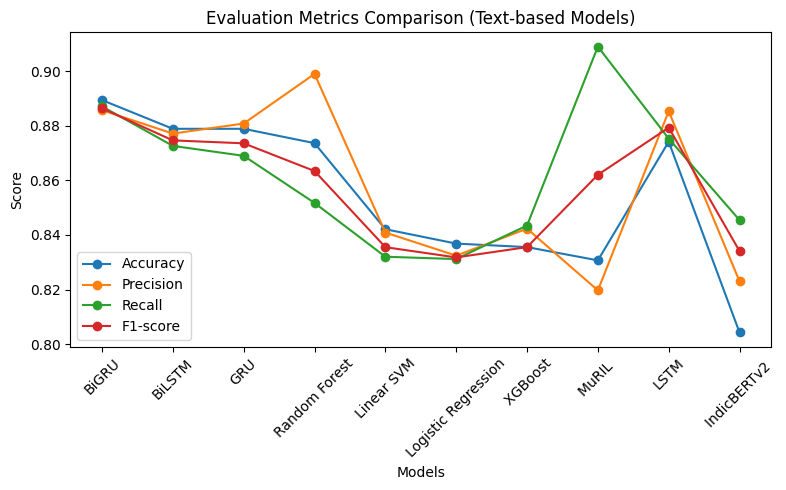

In [ ]:
import matplotlib.pyplot as plt

# Check column names (good practice)
print(df.columns)

# Create the figure
plt.figure(figsize=(8, 5))

# Plot each metric using CORRECT column names
plt.plot(df['model'], df['accuracy'], marker='o', label='Accuracy')
plt.plot(df['model'], df['precision_macro'], marker='o', label='Precision')
plt.plot(df['model'], df['recall_macro'], marker='o', label='Recall')
plt.plot(df['model'], df['f1_macro'], marker='o', label='F1-score')

# Labels and title
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Evaluation Metrics Comparison (Text-based Models)')

# Legend
plt.legend()

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
